In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from package_global_functions import *

latexFont(ticklabelssize=12,labelsize=14) # ticklabelssize=10, labelsize=12, legendsize=8

model = 'Galla'
pis = [0.3, 0.3]
qs = [7, 10]
lambs = [0.3, 0.6, 0.9]
lambs_colors_r = plt.cm.spring(np.linspace(0.1,0.9,len(lambs)))
lambs_colors_N = plt.cm.winter(np.linspace(0.1,0.9,len(lambs)))
lambs_colors = plt.cm.gnuplot(np.linspace(0.05, 0.9,len(lambs)))
lambs_colors = ['xkcd:blue', 'xkcd:green', 'xkcd:orange']
# lambs_colors = ['xkcd:blue', 'xkcd:green']
arena_r = 20
exclusion_r = 1.5

In [3]:
# percolation exponents:
nu, df_expo = 4/3, 182/96

def perc_dens(N:int):
    # return 11.0*N**(-1/(nu*df_expo)) + 1.1
    return 14.0*N**(-1/(nu*df_expo)) + 0.4
    # return np.exp(2.5638)*N**(-0.3747) + 0.4

def perc_r(N):
    # return 58.11*N**(-0.65)
    return 71.1796*N**(-0.6681)

use_rstar = True


mean_field = 'sim'
sols_lamb = []

if mean_field == 'analytic':
# mean field analytic solutions:
    pi1, pi2, q1, q2 = 0.3, 0.3, 7, 10
    
    for l in lambs:
        call(f'python ../det_sols_from_polynomial/f0poly_sols_clean.py {pi1} {pi2} {q1} {q2} {l} -v > sols.dat', shell=True)
        sols = []
        with open('sols.dat', 'r') as file:
            for line in file.readlines():
                sols_i = [float(f) for f in line.split()]
                sols.append(sols_i)
        sols_lamb.append(sols[1])
else:
    # mean field simulation results:
    # mean field simulation (N=35)
    dfmf = pd.read_csv('../figures_paper_model_and_kbs/sim_results.csv')
    dfmf = dfmf.rename(columns={'lambda':'lamb'})
    dfmf = dfmf.query('lamb <= 0.9')
    dfmf_sym = dfmf.query('q1 == @qs[0] & q2 == @qs[1] & pi1 == @pis[0] & pi2 == @pis[1]')
    for l in lambs:
        sols_lamb.append([float(dfmf_sym.query('lamb == @l')['f0'].iloc[0]),
                        float(dfmf_sym.query('lamb == @l')['f1'].iloc[0]),
                        float(dfmf_sym.query('lamb == @l')['f2'].iloc[0])])

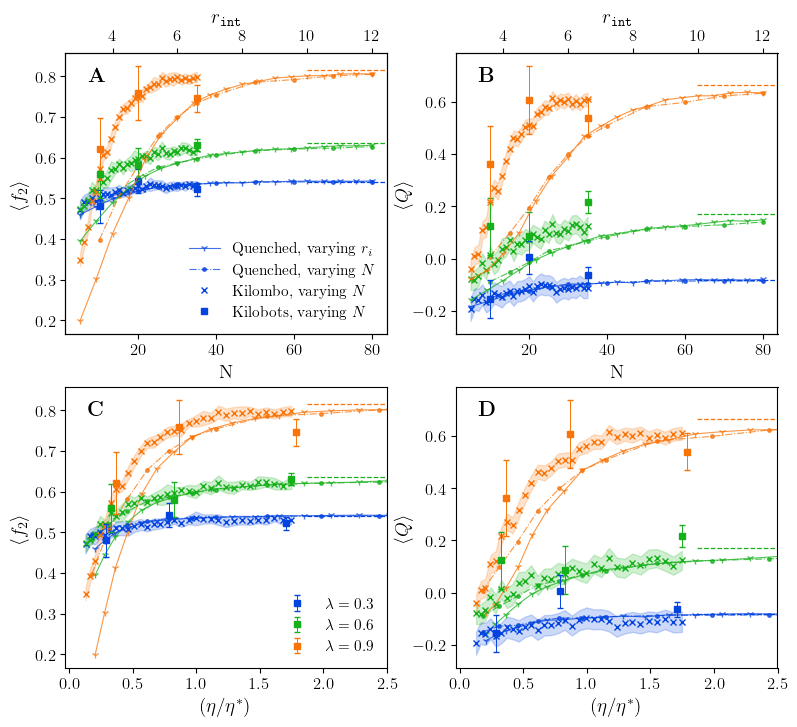

In [5]:
fig, ax = plt.subplots(2,2,figsize=(3.9*2,3.6*2))
ax[0,0].set(xlabel='N', ylabel=r'$\langle f_2 \rangle$')
ax[0,1].set(xlabel='N', ylabel=r'$\langle Q \rangle$')
ax[1,0].set(xlabel=r'$(\eta/\eta^*)$', ylabel=r'$\langle f_2 \rangle$')
ax[1,1].set(xlabel=r'$(\eta/\eta^*)$', ylabel=r'$\langle Q \rangle$')

ax[0,1].set_ylabel(r'$\langle Q \rangle$', labelpad=0.0)
ax[1,1].set_ylabel(r'$\langle Q \rangle$', labelpad=0.0)

ax_ir_f2 = ax[0,0].twiny()
ax_ir_Q = ax[0,1].twiny()
ax_ir_f2.set_xlabel(r'$r_{\tt int}$')
ax_ir_Q.set_xlabel(r'$r_{\tt int}$')

for l,sol_lamb,lcolor in zip(lambs, sols_lamb, lambs_colors):
    ax[0,0].axhline(sol_lamb[2], 0.75, 1.0, color=lcolor, lw=0.9, ls='--')
    ax[0,1].axhline(sol_lamb[2]-2*sol_lamb[1], 0.75, 1.0, color=lcolor, lw=0.9, ls='--')
    ax[1,0].axhline(sol_lamb[2], 0.75, 1.0, color=lcolor, lw=0.9, ls='--')
    ax[1,1].axhline(sol_lamb[2]-2*sol_lamb[1], 0.75, 1.0, color=lcolor, lw=0.9, ls='--')


# quenched simulations data, N = 35, varying interac_r
N = 35
perc_dens_fixN = perc_dens(N)
perc_r_fixN = perc_r(N)
df = pd.read_csv(f'{model}/{N}_bots/sim_fp_results_er_{exclusion_r}_NOPUSH.csv')
df = df.loc[(df['arena_r']==arena_r) & (df['pi1']==pis[0]) & (df['pi2']==pis[1]) & (df['q1']==qs[0]) & (df['q2']==qs[1])]
df = df[df.interac_r != 20.0]
df = df.rename(columns={"lambda":"lamb"})
for l,lcolor in zip(lambs,lambs_colors):
    dfl = df.query('lamb == @l')
    # labels to identify quenched/kilombo/kilobot
    if l == 0.3:
        ln1, = ax_ir_f2.plot(dfl['interac_r'], dfl['f2'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75, label='Quenched, varying $r_i$')
    else:
        ax_ir_f2.plot(dfl['interac_r'], dfl['f2'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)
    ax_ir_Q.plot(dfl['interac_r'], dfl['Q'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)
    # rescaled plots, choose if rescale by r* or p*
    if use_rstar:
        ax[1,0].plot((dfl['interac_r']/perc_r_fixN)**2, dfl['f2'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)
        ax[1,1].plot((dfl['interac_r']/perc_r_fixN)**2, dfl['Q'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)
    else:
        ax[1,0].plot(N*(dfl['interac_r']/arena_r)**2/perc_dens_fixN, dfl['f2'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)
        ax[1,1].plot(N*(dfl['interac_r']/arena_r)**2/perc_dens_fixN, dfl['Q'], color=lcolor, marker='1', markersize=5, lw=0.8, alpha=0.75)


# quenched simulations data, interac_r = 6.5, varying N
interac_r = 6.5
Ns = [10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
for l,lcolor in zip(lambs,lambs_colors):
    f1_dif_N, f2_dif_N = [], []
    for N in Ns:
        df = pd.read_csv(f'{model}/{N}_bots/sim_fp_results_er_{exclusion_r}_NOPUSH.csv')
        df = df.rename(columns={"lambda":"lamb"})
        df = df.query('arena_r == @arena_r & pi1 == @pis[0] & pi2 == @pis[1] & q1 == @qs[0] & q2 == @qs[1] & lamb == @l & interac_r == @interac_r')
        f1_dif_N.append(float(df['f1'].iloc[0])), f2_dif_N.append(float(df['f2'].iloc[0]))
    perc_r_difN = perc_r(np.array(Ns))
    perc_dens_difN = perc_dens(np.array(Ns))
    Q_dif_N = [f2-2*f1 for f2,f1 in zip(f2_dif_N, f1_dif_N)]
    # labels to identify quenched/kilombo/kilobot
    if l == 0.3:
        ln2, = ax[0,0].plot(Ns, f2_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.', label='Quenched, varying $N$')
    else:
        ax[0,0].plot(Ns, f2_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')
    ax[0,1].plot(Ns, Q_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')
    # rescaled plots, choose if rescale by r* or p*
    if use_rstar:
        ax[1,0].plot((interac_r/perc_r_difN)**2, f2_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')
        ax[1,1].plot((interac_r/perc_r_difN)**2, Q_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')
    else:
        ax[1,0].plot(np.array(Ns)*(interac_r/arena_r)**2/perc_dens_difN, f2_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')
        ax[1,1].plot(np.array(Ns)*(interac_r/arena_r)**2/perc_dens_difN, Q_dif_N, color=lcolor, marker='.', markersize=5, lw=0.8, alpha=0.75, ls='-.')


# Kilombo simulations data, varying N 
factor = 4.0/7.0
# factor = 0.5
# factor = 3.75/7.0 # fals
interac_r = 5.0
for l,lcolor in zip(lambs,lambs_colors):
    dfl = pd.read_csv(f'other_res_files/av_freq_vs_N_lambda{l}_c100.dat', sep='\s+', names=['N', 'f0', 'sdf0', 'f1', 'sdf1', 'f2', 'sdf2', 'Ndata'])
    dfl['perc_dens'] = factor**2 * perc_dens(dfl['N'])
    dfl['perc_r'] = factor * perc_r(dfl['N'])
    dfl['Q'] = dfl['f2'] - 2*dfl['f1']
    dfl['sdQ'] = np.sqrt(4*(dfl['sdf1']/40)**2 + dfl['sdf2']**2)
    # labels to identify quenched/kilombo/kilobot
    if l == 0.3:
        ln3, = ax[0,0].plot(dfl['N'], dfl['f2'], color=lcolor, marker='x', markersize=4, lw=0.0, label='Kilombo, varying $N$')
    else:
        ax[0,0].plot(dfl['N'], dfl['f2'], color=lcolor, marker='x', markersize=4, lw=0.0)
    ax[0,0].fill_between(dfl['N'], dfl['f2']-dfl['sdf2'], dfl['f2']+dfl['sdf2'], color=lcolor, alpha=0.2)
    ax[0,1].plot(dfl['N'], dfl['Q'], color=lcolor, marker='x', markersize=4, lw=0.0)
    ax[0,1].fill_between(dfl['N'], dfl['Q']-dfl['sdQ'], dfl['Q']+dfl['sdQ'], color=lcolor, alpha=0.2)
    # rescaled plots, choose if rescale by r* or p*
    if use_rstar:
        ax[1,0].plot((interac_r/dfl['perc_r'])**2, dfl['f2'], color=lcolor, marker='x', markersize=4, lw=0.0)
        ax[1,0].fill_between((interac_r/dfl['perc_r'])**2, dfl['f2']-dfl['sdf2'], dfl['f2']+dfl['sdf2'], color=lcolor, alpha=0.2)
        ax[1,1].plot((interac_r/dfl['perc_r'])**2, dfl['Q'], color=lcolor, marker='x', markersize=4, lw=0.0)
        ax[1,1].fill_between((interac_r/dfl['perc_r'])**2, dfl['Q']-dfl['sdQ'], dfl['Q']+dfl['sdQ'], color=lcolor, alpha=0.2)
    else:
        ax[1,0].plot(dfl['N']*(interac_r/arena_r)**2/dfl['perc_dens'], dfl['f2'], color=lcolor, marker='x', markersize=4, lw=0.0)
        ax[1,0].fill_between(dfl['N']*(interac_r/arena_r)**2/dfl['perc_dens'], dfl['f2']-dfl['sdf2'], dfl['f2']+dfl['sdf2'], color=lcolor, alpha=0.2)
        ax[1,1].plot(dfl['N']*(interac_r/arena_r)**2/dfl['perc_dens'], dfl['Q'], color=lcolor, marker='x', markersize=4, lw=0.0)
        ax[1,1].fill_between(dfl['N']*(interac_r/arena_r)**2/dfl['perc_dens'], dfl['Q']-dfl['sdQ'], dfl['Q']+dfl['sdQ'], color=lcolor, alpha=0.2)


# Kilobot experiments data, varying N
interac_r = 5.0
jitterer_xax = [-0.04, 0.0, 0.04]
df = pd.read_csv('other_res_files/kilobot_statVals_varN_varl_useLastIters_corrected_pi1_0.3_pi2_0.3_q1_7_q2_10.csv')
for l,lcolor,jit in zip(lambs,lambs_colors,jitterer_xax):
    dfl = df.query('lamb == @l').copy()
    dfl['perc_r'] = factor * perc_r(dfl['N'])
    dfl['perc_dens'] = factor**2 * perc_dens(dfl['N'])
    dfl['Q'] = dfl['f2_avg'] - 2*dfl['f1_avg']
    dfl['sdQ'] = np.sqrt(4*dfl['f1_std_trajs']**2 + dfl['f2_std_trajs']**2)
    # labels to identify quenched/kilombo/kilobot
    if l == 0.3:
        ebar_container = ax[0,0].errorbar(dfl['N'], dfl['f2_avg'], dfl['f2_std_trajs'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                    elinewidth=0.7, capsize=2.0, label = 'Kilobots, varying $N$')
        ln4 = ebar_container[0]
        ln4.set_label('Kilobots, varying $N$')
    else:
        ax[0,0].errorbar(dfl['N'], dfl['f2_avg'], dfl['f2_std_trajs'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                    elinewidth=0.7, capsize=2.0)
    ax[0,1].errorbar(dfl['N'], dfl['Q'], dfl['sdQ'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                    elinewidth=0.7, capsize=2.0)
    # rescaled plots, choose if rescale by r* or p*
    if use_rstar:
        ax[1,0].errorbar((interac_r/dfl['perc_r'])**2+jit, dfl['f2_avg'], dfl['f2_std_trajs'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                        elinewidth=0.7, capsize=2.0, label=rf'$\lambda = {l}$')
        ax[1,1].errorbar((interac_r/dfl['perc_r'])**2+jit, dfl['Q'], dfl['sdQ'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                        elinewidth=0.7, capsize=2.0)
    else:
        ax[1,0].errorbar((dfl['N']*(interac_r/arena_r)**2)/dfl['perc_dens']+jit, dfl['f2_avg'], dfl['f2_std_trajs'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                        elinewidth=0.7, capsize=2.0, label=rf'$\lambda = {l}$')
        ax[1,1].errorbar((dfl['N']*(interac_r/arena_r)**2)/dfl['perc_dens']+jit, dfl['Q'], dfl['sdQ'], color=lcolor, marker='s', markersize=4, lw=0.0, 
                        elinewidth=0.7, capsize=2.0)
    

# data type legend:
lns = [ln1, ln2, ln3, ln4]
# as errobar does not save the label in the line object and the workaround is too much
# https://stackoverflow.com/questions/19470104/python-matplotlib-errorbar-legend-picking
# I do this ugly workaround
# labels = [ln.get_label() for ln in lns[:-1]]
# labels.append(r'Kilobots, varying $N$')
labels = [ln.get_label() for ln in lns]
ax[0,0].legend(lns, labels, fontsize=11, frameon=False)

# lambda legend:
ax[1,0].legend(fontsize=11, frameon=False)

# plot A, B, C, D label:
ax[0,0].text(0.07, 0.9, r'\textbf{A}', transform=ax[0,0].transAxes)
ax[0,1].text(0.07, 0.9, r'\textbf{B}', transform=ax[0,1].transAxes)
ax[1,0].text(0.07, 0.9, r'\textbf{C}', transform=ax[1,0].transAxes)
ax[1,1].text(0.07, 0.9, r'\textbf{D}', transform=ax[1,1].transAxes)

if factor == 4.0/7.0:
    ax[1,0].set(xlim=(None,2.5))
    ax[1,1].set(xlim=(None,2.5))
elif factor == 0.5:
    ax[1,0].set(xlim=(None,3.0))
    ax[1,1].set(xlim=(None,3.0))

fig.tight_layout(pad=0.3)
if use_rstar:
    fig.savefig('scaling_multiplot_f2_Q_reescale_rstar.pdf')
else:
    fig.savefig('scaling_multiplot_f2_Q_reescale_etastar.pdf')